In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

In [2]:
SEED = 42
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 500
FREQ_MAX = 15000
MAX_AUDIO_FILES = 100
WIN_LENGHT = 128
AUDIO_PATH = "/app/_data/train_short_audio/"

In [3]:
train_soundscape_labels = pd.read_csv("/app/_data/train_soundscape_labels_orig.csv")
train_metadata = pd.read_csv("/app/_data/train_metadata_orig.csv")
test = pd.read_csv("/app/_data/test.csv")
test_dates = pd.read_csv("/app/_data/test_soundscapes/test_set_recording_dates.csv")

# train_soundscape_labels

In [4]:
train_soundscape_labels

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall
...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall
2396,54955_SSW_585,SSW,54955,585,grycat
2397,54955_SSW_590,SSW,54955,590,grycat
2398,54955_SSW_595,SSW,54955,595,nocall


In [5]:
ss_df = pd.DataFrame()
for mel_name in os.listdir("/app/_data/train_soundscapes/"):
    mel_name_full = mel_name
    mel_name = mel_name[:-4].split("_")
    ss_df = ss_df.append(
        {
            "audio_id": np.int(mel_name[0]),
            "date": mel_name[-1],
            "file_path": "/app/_data/train_soundscapes/" + mel_name_full,
        },
        ignore_index=True,
    )

In [6]:
train_soundscape_labels = train_soundscape_labels.merge(
    ss_df, on="audio_id", how="outer"
)

In [7]:
train_soundscape_labels["date"] = pd.to_datetime(
    train_soundscape_labels["date"], format="%Y%m%d"
)

In [8]:
list_sites = []
for file_name in os.listdir("/app/_data/test_soundscapes/txt"):
    if file_name[-3:] == "txt":
        with open("/app/_data/test_soundscapes/txt/" + file_name, "r") as f:
            site = f.readlines()
            list_sites.append([file_name.split("_")[0], site[-2:]])

In [9]:
coord_sites = pd.DataFrame()
for i in list_sites:
    ids = i[0]
    coord_sites.loc[ids, "longitude"] = i[1][1].split(":")[1].split("\n")[0].split()[0]
    coord_sites.loc[ids, "latitude"] = i[1][0].split(":")[1].split("\n")[0].split()[0]
coord_sites = coord_sites.astype("float")
coord_sites["site"] = coord_sites.index

In [10]:
coord_sites

,longitude,latitude,site
COR,-84.51,10.12,COR
SNE,-119.95,38.49,SNE
SSW,-76.45,42.47,SSW
COL,-75.85,5.57,COL


In [11]:
train_soundscape_labels = train_soundscape_labels.merge(
    coord_sites, on="site", how="left"
)

In [12]:
train_soundscape_labels["month"] = train_soundscape_labels["date"].dt.month
train_soundscape_labels["year"] = train_soundscape_labels["date"].dt.year

In [13]:
train_soundscape_labels

,row_id,site,audio_id,seconds,birds,date,file_path,longitude,latitude,month,year
0,7019_COR_5,COR,7019,5,nocall,2019-09-04,/app/_data/train_soundscapes/7019_COR_20190904...,-84.51,10.12,9,2019
1,7019_COR_10,COR,7019,10,nocall,2019-09-04,/app/_data/train_soundscapes/7019_COR_20190904...,-84.51,10.12,9,2019
2,7019_COR_15,COR,7019,15,nocall,2019-09-04,/app/_data/train_soundscapes/7019_COR_20190904...,-84.51,10.12,9,2019
3,7019_COR_20,COR,7019,20,nocall,2019-09-04,/app/_data/train_soundscapes/7019_COR_20190904...,-84.51,10.12,9,2019
4,7019_COR_25,COR,7019,25,nocall,2019-09-04,/app/_data/train_soundscapes/7019_COR_20190904...,-84.51,10.12,9,2019
...,...,...,...,...,...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,2017-06-17,/app/_data/train_soundscapes/54955_SSW_2017061...,-76.45,42.47,6,2017
2396,54955_SSW_585,SSW,54955,585,grycat,2017-06-17,/app/_data/train_soundscapes/54955_SSW_2017061...,-76.45,42.47,6,2017
2397,54955_SSW_590,SSW,54955,590,grycat,2017-06-17,/app/_data/train_soundscapes/54955_SSW_2017061...,-76.45,42.47,6,2017
2398,54955_SSW_595,SSW,54955,595,nocall,2017-06-17,/app/_data/train_soundscapes/54955_SSW_2017061...,-76.45,42.47,6,2017


# train_metadata

In [14]:
train_metadata

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62869,yetvir,[],"['adult', 'male', 'song']",30.2150,-97.6505,Vireo flavifrons,Yellow-throated Vireo,Caleb Helsel,2020-07-10,XC591680.ogg,Creative Commons Attribution-NonCommercial-Sha...,1.0,08:30,https://www.xeno-canto.org/591680
62870,yetvir,[],"['life stage uncertain', 'sex uncertain', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2019-05-31,XC600085.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,09:30,https://www.xeno-canto.org/600085
62871,yetvir,"['amered', 'eawpew', 'norcar', 'reevir1']","['adult', 'male', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2020-06-02,XC602701.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,08:30,https://www.xeno-canto.org/602701
62872,yetvir,[],['uncertain'],32.2357,-99.8811,Vireo flavifrons,Yellow-throated Vireo,Brad Banner,2019-04-27,XC614733.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,17:30,https://www.xeno-canto.org/614733


In [15]:
train_metadata["month"] = train_metadata["date"].apply(lambda x: x.split("-")[1])
train_metadata["month"] = train_metadata["month"].astype("int")
train_metadata["year"] = train_metadata["date"].apply(lambda x: x.split("-")[0])
train_metadata["year"] = train_metadata["year"].astype("int")

In [16]:
train_metadata["type"] = train_metadata["type"].str.replace(r"[\[\]\'\"\(\)?]", "")
train_metadata["secondary_labels"] = train_metadata["secondary_labels"].str.replace(
    r"[\[\]\',]", ""
)

In [17]:
def get_audio_info(filepath):
    """Get some properties from  an audio file"""
    with soundfile.SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames) / sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [18]:
for ids in train_metadata.index.tolist():
    bird = train_metadata.loc[ids, "primary_label"]
    path = AUDIO_PATH + bird
    record = train_metadata.loc[ids, "filename"]
    audio_info = get_audio_info(os.path.join(path, record))
    train_metadata.loc[ids, "file_path"] = os.path.join(path, record)
    train_metadata.loc[ids, "frames"] = audio_info["frames"]
    train_metadata.loc[ids, "sr"] = audio_info["sr"]
    train_metadata.loc[ids, "duration"] = audio_info["duration"]

In [19]:
train_metadata[train_metadata["secondary_labels"].str.contains("rocpig1")][
    "secondary_labels"
].values

array(['rocpig1', 'rocpig1', 'rocpig1', 'rocpig1 solsan whtdov',
       'rocpig1 grtgra', 'rocpig1', 'rocpig1', 'rocpig1',
       'rewbla rocpig1 cangoo saypho killde amerob'], dtype=object)

In [20]:
train_metadata["secondary_labels"] = train_metadata["secondary_labels"].replace(
    "rocpig1", "rocpig"
)

In [21]:
train_metadata["secondary_labels"] = train_metadata["secondary_labels"].replace(
    {
        "rocpig1 solsan whtdov": "rocpig solsan whtdov",
        "rocpig1 grtgra": "rocpig grtgra",
        "rewbla rocpig1 cangoo saypho killde amerob": "rewbla rocpig cangoo saypho killde amerob",
    }
)

In [22]:
train_metadata.to_csv("/app/_data/train_metadata_full.csv", index=False)

In [23]:
train_metadata = train_metadata[
    [
        "primary_label",
        "secondary_labels",
        "latitude",
        "longitude",
        "date",
        "filename",
        "rating",
        "month",
        "year",
        "file_path",
        "frames",
        "duration",
    ]
]

# concat

In [24]:
train_soundscape_labels = train_soundscape_labels[
    ["row_id", "birds", "date", "file_path", "longitude", "latitude", "month", "year"]
]
train_soundscape_labels.columns = [
    "row_id",
    "primary_label",
    "date",
    "file_path",
    "longitude",
    "latitude",
    "month",
    "year",
]

In [25]:
train_soundscape_labels["filename"] = train_soundscape_labels["file_path"].apply(
    lambda x: x.split("/")[-1]
)
train_soundscape_labels["rating"] = 6
train_soundscape_labels["frames"] = 32000 * 5
train_soundscape_labels["duration"] = 5

In [26]:
train_soundscape_labels.to_csv(
    "/app/_data/train_soundscape_labels_full.csv", index=False
)

In [27]:
all_audio = pd.concat(
    [train_metadata, train_soundscape_labels], axis=0, ignore_index=True
)

In [28]:
# all_audio1 = pd.read_csv("/app/_data/all_audio.csv")

In [29]:
all_audio

,primary_label,secondary_labels,latitude,longitude,date,filename,rating,month,year,file_path,frames,duration,row_id
0,acafly,amegfi,35.3860,-84.1250,2012-08-12,XC109605.ogg,2.5,8,2012,/app/_data/train_short_audio/acafly/XC109605.ogg,2037586.0,63.674563,NaN
1,acafly,,9.1334,-79.6501,2000-12-26,XC11209.ogg,3.0,12,2000,/app/_data/train_short_audio/acafly/XC11209.ogg,532933.0,16.654156,NaN
2,acafly,,5.7813,-75.7452,2012-01-10,XC127032.ogg,3.0,1,2012,/app/_data/train_short_audio/acafly/XC127032.ogg,1508450.0,47.139063,NaN
3,acafly,whwbec1,4.6717,-75.6283,2009-06-19,XC129974.ogg,3.5,6,2009,/app/_data/train_short_audio/acafly/XC129974.ogg,450177.0,14.068031,NaN
4,acafly,whwbec1,4.6717,-75.6283,2009-06-19,XC129981.ogg,3.5,6,2009,/app/_data/train_short_audio/acafly/XC129981.ogg,1301142.0,40.660688,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65269,nocall,NaN,42.4700,-76.4500,2017-06-17 00:00:00,54955_SSW_20170617.ogg,6.0,6,2017,/app/_data/train_soundscapes/54955_SSW_2017061...,160000.0,5.000000,54955_SSW_580
65270,grycat,NaN,42.4700,-76.4500,2017-06-17 00:00:00,54955_SSW_20170617.ogg,6.0,6,2017,/app/_data/train_soundscapes/54955_SSW_2017061...,160000.0,5.000000,54955_SSW_585
65271,grycat,NaN,42.4700,-76.4500,2017-06-17 00:00:00,54955_SSW_20170617.ogg,6.0,6,2017,/app/_data/train_soundscapes/54955_SSW_2017061...,160000.0,5.000000,54955_SSW_590
65272,nocall,NaN,42.4700,-76.4500,2017-06-17 00:00:00,54955_SSW_20170617.ogg,6.0,6,2017,/app/_data/train_soundscapes/54955_SSW_2017061...,160000.0,5.000000,54955_SSW_595


In [30]:
for i in all_audio.index.tolist():
    if all_audio.loc[i, "secondary_labels"] == "":
        all_audio.loc[i, "secondary_labels"] = "nocall"

In [31]:
all_audio["secondary_labels"] = all_audio["secondary_labels"].fillna("nocall")
all_audio["sin_month"] = np.sin(2 * np.pi * all_audio["month"] / 12)
all_audio["cos_month"] = np.cos(2 * np.pi * all_audio["month"] / 12)
all_audio["sin_longitude"] = np.sin(2 * np.pi * (all_audio["longitude"]) / 360)
all_audio["cos_longitude"] = np.cos(2 * np.pi * (all_audio["longitude"]) / 360)
all_audio["norm_latitude"] = (all_audio["latitude"] - all_audio["latitude"].min()) / (
    all_audio["latitude"].max() - all_audio["latitude"].min()
)

In [32]:
all_audio = all_audio[all_audio["primary_label"].str.len() <= 7]
dict_birds = {}
for i, bird in enumerate(sorted(all_audio["primary_label"].unique())):
    dict_birds[bird] = i
all_audio["label_id"] = all_audio["primary_label"].replace(dict_birds)

In [33]:
dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
all_audio["num_intervals"] = all_audio["duration"] // 5
all_audio["start_sec"] = 0
all_audio["end_sec"] = 5

In [34]:
for i in all_audio.index.tolist():
    labels = all_audio.loc[i, "secondary_labels"].split(" ")
    list_ids = []
    for bird in labels:
        list_ids.append(str(dict_birds[bird]))
    all_audio.loc[i, "secondary_labels_id"] = " ".join(list_ids)

In [35]:
file_json = open("/app/_data/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()

In [36]:
# with open("/app/_data/dict_birds.json", "r") as d:
#     dict_birds = json.load(d)

In [37]:
all_audio.sample()

,primary_label,secondary_labels,latitude,longitude,date,filename,rating,month,year,file_path,...,cos_month,sin_longitude,cos_longitude,norm_latitude,label_id,class_weights,num_intervals,start_sec,end_sec,secondary_labels_id
23714,gcrwar,nocall,-22.4902,-44.5679,2007-09-15,XC195449.ogg,3.0,9,2007,/app/_data/train_short_audio/gcrwar/XC195449.ogg,...,-1.836970e-16,-0.701754,0.712419,0.232204,143,0.005525,9.0,0,5,220


In [107]:
all_audio.to_csv("/app/_data/all_audio_initial.csv")

# chunks

In [38]:
def my_floor(a, precision=2):
    dec = a - np.floor(a)
    dec = dec * 10 ** precision
    dec = np.floor(dec) / 10 ** precision
    b = np.floor(a) + dec
    return b

In [39]:
def make_segments(row, sig_lenght, ordered=True, rand=False):
    duration = row["duration"]
    max_num_intervals = int(duration // sig_lenght)
    if ordered:
        if max_num_intervals == 1:
            if duration >= 7:
                intervals = [
                    [0, sig_lenght],
                    [my_floor(duration - sig_lenght), my_floor(duration)],
                ]
            else:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]
        elif max_num_intervals == 2:
            center = my_floor((duration - sig_lenght) / 2)
            intervals = [
                [0, sig_lenght],
                [my_floor(center), my_floor(center + sig_lenght)],
                [my_floor(duration - sig_lenght), my_floor(duration)],
            ]
        else:
            intervals = []
            for i in range(max_num_intervals):
                intervals.append([i * sig_lenght, (i + 1) * sig_lenght])
            if duration % sig_lenght >= 2:
                intervals.append([my_floor(duration - sig_lenght), my_floor(duration)])
    if rand:
        if max_num_intervals == 1:
            if duration >= 7:
                start1 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                start2 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [
                    [start1, my_floor(start1 + sig_lenght)],
                    [start2, my_floor(start2 + sig_lenght)],
                ]
            elif 6 <= duration<7:
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [my_floor(start),my_floor( start + sig_lenght)]
            elif duration<6:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]

        elif max_num_intervals == 2:
            intervals = []
            for i in range(3):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start),my_floor( start + sig_lenght)])
        else:
            intervals = []
            for i in range(max_num_intervals):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start),my_floor( start + sig_lenght)])
    new_row = row.copy()
    df = pd.DataFrame(columns=row1.index.tolist())
    if max_num_intervals==1 and duration < 7:
        start = intervals[0]
        end = intervals[1]
        new_row['start_sec'] = start
        new_row['end_sec'] = end
        new_row['row_id'] = new_row['filename']+'_'+'_'.join(str(end).split('.'))
        df.loc[0] = new_row
    else:
        for i in range(len(intervals)):
            start = intervals[i][0]
            end = intervals[i][1]
            new_row['start_sec'] = start
            new_row['end_sec'] = end
            new_row['row_id'] = new_row['filename']+'_'+'_'.join(str(end).split('.'))
            df.loc[i] = new_row

    return  df

In [83]:
def make_segments(row, sig_lenght, ordered=True, rand=False):
    duration = row[1]
    max_num_intervals = int(duration // sig_lenght)
    dict_intervals = []
    if ordered:
        if max_num_intervals == 1:
            if duration >= 7:
                intervals = [
                    [0, sig_lenght],
                    [my_floor(duration - sig_lenght), my_floor(duration)],
                ]
            else:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]
        elif max_num_intervals == 2:
            center = my_floor((duration - sig_lenght) / 2)
            intervals = [
                [0, sig_lenght],
                [my_floor(center), my_floor(center + sig_lenght)],
                [my_floor(duration - sig_lenght), my_floor(duration)],
            ]
        else:
            intervals = []
            for i in range(max_num_intervals):
                intervals.append([i * sig_lenght, (i + 1) * sig_lenght])
            if duration % sig_lenght >= 2:
                intervals.append([my_floor(duration - sig_lenght), my_floor(duration)])
    if rand:
        if max_num_intervals == 1:
            if duration >= 7:
                start1 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                start2 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [
                    [start1, my_floor(start1 + sig_lenght)],
                    [start2, my_floor(start2 + sig_lenght)],
                ]
            elif 6 <= duration<7:
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [my_floor(start),my_floor( start + sig_lenght)]
            elif duration<6:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]

        elif max_num_intervals == 2:
            intervals = []
            for i in range(3):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start),my_floor( start + sig_lenght)])
        else:
            intervals = []
            for i in range(max_num_intervals):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start),my_floor( start + sig_lenght)])
#     dict_intervals[0] = row[0]
#     dict_intervals[1] = intervals
#     dict_intervals[row[0]] = intervals
    intervals.append(row[0])
    if max_num_intervals==1 and duration < 7:
        start = intervals[0]
        end = intervals[1]
    else:
        for i in range(len(intervals)):
            start = intervals[i][0]
            end = intervals[i][1]
            
    return  intervals

In [45]:
short_audio_df = all_audio[
    ~all_audio["file_path"].str.contains("train_soundscapes")
].reset_index(drop=True)

In [102]:
short_audio_df.index = short_audio_df['filename']

In [54]:
array_for_cut = short_audio_df[['filename', 'duration']].values

In [82]:
array_for_cut[0][0]

'XC109605.ogg'

In [87]:
a = make_segments(array_for_cut[2], 5, ordered=False, rand=True)

In [92]:
np.array(b[: -1])

array([[ 8.22, 13.22],
       [ 8.08, 13.08],
       [10.23, 15.23]])

In [93]:
d = {}
d[b[-1]] = np.array(b[:-1])
d[a[-1]] = np.array(a[:-1])

In [97]:
d['XC11209.ogg'].shape

(3, 2)

In [100]:
ord_cut = {}
for i in tqdm(range(len(array_for_cut))):
    row = array_for_cut[i]
    seg = make_segments(row, 5, ordered=True, rand=False)
    ord_cut[seg[-1]] = np.array(seg[:-1])

100%|██████████| 62874/62874 [00:03<00:00, 18821.16it/s]


In [119]:
ord_cut['XC454273.ogg']

array([0.98, 5.98])

In [116]:
col = [
    "rating",
    "filename",
    "row_id",
    "class_weights",
    "start_sec",
    "end_sec",
]

In [117]:
short_audio_df1 = short_audio_df[col]

In [ ]:
df = pd.DataFrame(columns=col)
for key in tqdm(ord_cut):
    row = short_audio_df1.loc[key]
#     print(key)
    for i in ord_cut[key]:
        try:
            start = i[0]
            end=i[1]
        except:
            start = i
            end = 1+5
        filename = key.split('.')[0]+'_'+'_'.join(str(end).split('.'))
        row['start_sec'] = start
        row['end_sec'] = end
        row['row_id']= filename
        df.loc[filename] = row

 53%|█████▎    | 33423/62874 [5:39:49<14:32:41,  1.78s/it] 

In [126]:
aa = {'a': {'b':1, 'c':2}}

In [134]:
aa['a']['b'] = [1,3]

In [135]:
aa

{'a': {'b': [1, 3], 'c': 2}}

In [136]:
dict_ordered = {}
for key in tqdm(ord_cut):
    for i in ord_cut[key]:
        try:
            start = i[0]
            end=i[1]
        except:
            start = i
            end = 1+5
        filename = key.split('.')[0]+'_'+'_'.join(str(end).split('.'))
        dict_ordered[key] = filename
        dict_ordered[key][filename] = [start, end]

  0%|          | 0/62874 [00:00<?, ?it/s]


TypeError: 'str' object does not support item assignment

In [46]:
random_cut = pd.DataFrame(columns=all_audio.columns)
for i in tqdm(range(len(short_audio_df))):
    row = short_audio_df.loc[i]
#     print(i)
    df = make_segments(row, 5, ordered=False, rand=True)
    random_cut = pd.concat([random_cut, df], axis=0, ignore_index=True)

100%|██████████| 62874/62874 [7:54:15<00:00,  2.21it/s]   


In [47]:
random_cut.to_csv('/app/_data/random_cut1.csv', index=False)

In [49]:

for i in tqdm(range(len(short_audio_df))):
    row = short_audio_df.loc[i]
#     print(i)
    df = make_segments(row, 5, ordered=True, rand=False)
    ordered_cut = pd.concat([ordered_cut, df], axis=0, ignore_index=True)

  0%|          | 155/62874 [00:28<3:13:47,  5.39it/s]


KeyboardInterrupt: 

In [ ]:
ordered_cut.to_csv('/app/_data/ordered_cut1.csv', index=False)

In [121]:
random_cut_sample = random_cut.sample(n=40000, weights='class_weights', random_state = SEED)

<AxesSubplot:>

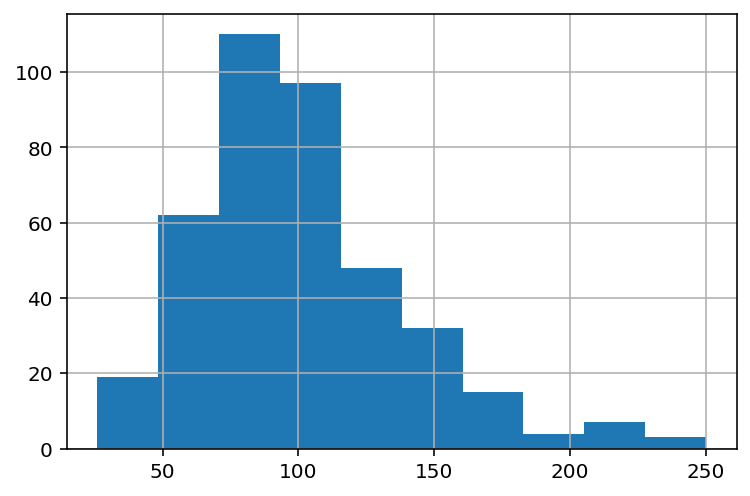

In [124]:
random_cut_sample['label_id'].value_counts().hist()

<AxesSubplot:>

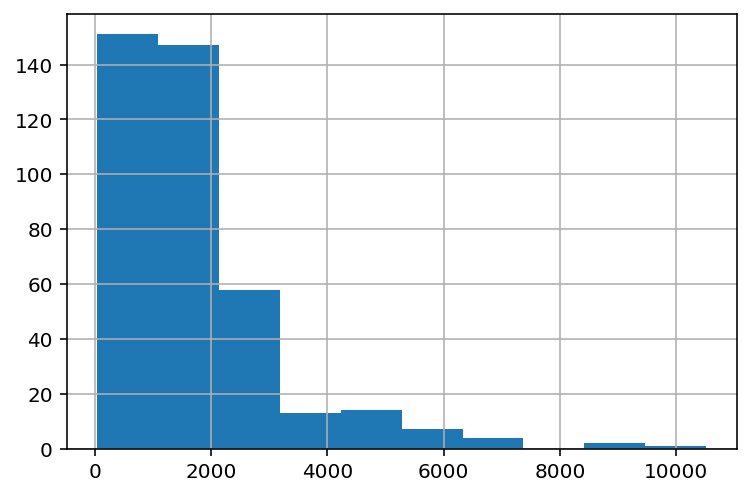

In [125]:
random_cut['label_id'].value_counts().hist()